## Urban Noise Detection:

In this notebook we tackle the urban noise classification problem.

A Dataset of 8732 labeled .wav files are obtained form (https://urbansounddataset.weebly.com/urbansound.html).

Features are extracted and used to train classification algorithms.

Performance is assessed and discussed.



In [1]:
#import needed libraries

import librosa as lb #used for feature extracion and resampling
import numpy as np 
import matplotlib.pyplot as plt
import librosa.display #builds on matplotlib to draw nice spectrograms.
import IPython.display as ipd #used to play .wav files from notebook
import pandas as pd 
# from scipy.io import wavfile #can be used to import .wav files but does not work on 24 bit depth audio files


import soundfile as sf #soundfile enables loading 24 bit depth audio files.
import time #used to measure code runtime. 
import pickle
import glob
from collections import defaultdict

In [2]:
#functions to be used in this exercise:

#function to read wave file and get numpy file:

def ReadAudio(filename):
    x, sr = sf.read(filename)
    x = x.T #transpose to match format of librosa array representation
    
    #set sample rate at 22050 to reduce memory usage. 
    x = lb.resample(x, sr, 22050)
        
    #change any stereo audio to mono.
    if x.shape[0] == 2:
        x = lb.to_mono(x)
     
    #change to a list.
    return x, 22050




## The first step is visualizing the sounds as numpy arrays. We begin with getting the ID and their corresponding labels.

We also note that the data has been divided into 10 folds. The fold number is shown in the dataframe below.

The folds have been organized by the compilers of the sounds. They have been done in such a way that different folds do not have related sounds.

In [3]:
key=pd.read_csv('AllData/UrbanSound8K/metadata/UrbanSound8K.csv')
key.head()


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [4]:
print('The DataFrame has {} entries, {} unique slice_file_names, and {} unique fsIDs'\
      .format(len(key)
        ,len(key.slice_file_name.unique()),
        len(key.fsID.unique())))

The DataFrame has 8732 entries, 8732 unique slice_file_names, and 1297 unique fsIDs


What we can see from above is that some sounds have similar fsIDs. Which means they probably are different slices of the same audio files. Two sounds from the same fsID are probably highly correlated. We check to see if there are fsIDs that repeat in different folds.

In [5]:
A=pd.crosstab(key['fsID'],key['fold'])

A=A!=0 #so we get a 1 is a fold contains the fsid
A=A.astype(int) #change from boolean to integer
#print(A.head())


#we check to see that the sum of each row is just 1 (which means no fsID appears in more than one fold)
Sums=A.sum(axis=1).values

#we also look at how many fsIDs are in more than one fold:
unique,counts=np.unique(Sums,return_counts=True)
print(np.asarray((unique,counts)).T)


[[   1 1292]
 [   2    5]]


We see from above that most fsIDs only appear in one fold (1292), when 5 appear in more 2 folds.
Despite having 5 fsIDS that exist in different folds, the split can be seen as acceptable.


## Feature Visualization

We get 2 sounds from each class.

In [6]:
labels=key['class'].unique()

samples=defaultdict(list)

for label in labels:
    sub=key[key['class']==label]
    samples[label].extend(list(sub.slice_file_name.values[[2,10]]))
    samples[label+'fold'].extend(list(sub.fold.values[[2,10]]))
    print(sub['fsID'].values[[2,10]])

[100652 101281]
[100263 101382]
[100648 118496]
[100852 100852]
[101848 105425]
[110622 135526]
[102853 102871]
[102857 102857]
[103074 103074]
[103199 103199]


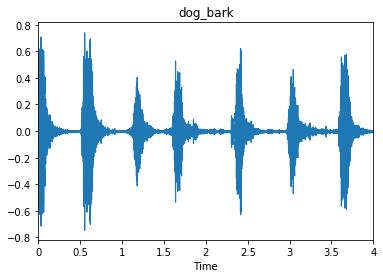

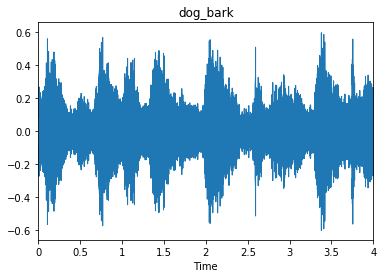

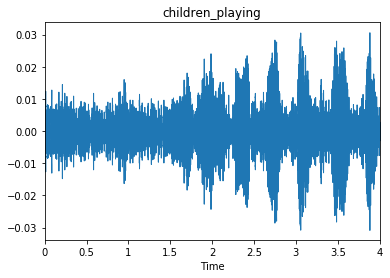

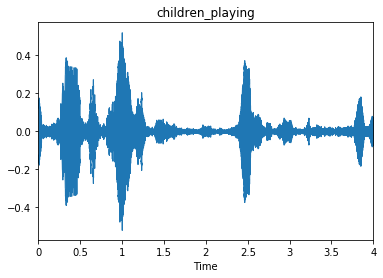

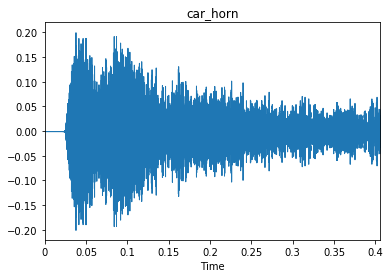

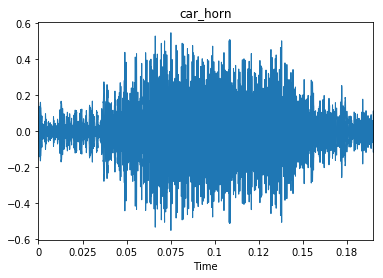

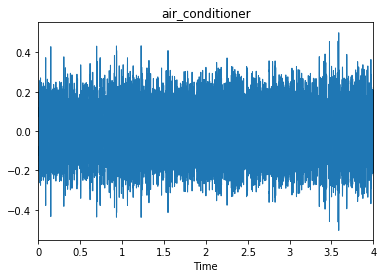

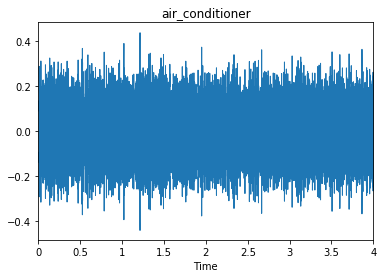

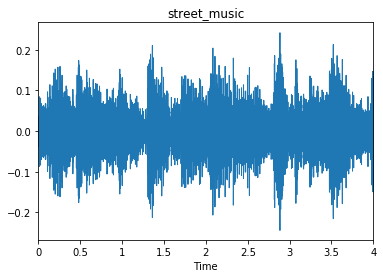

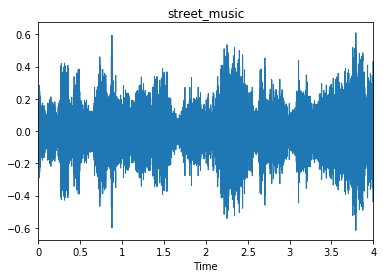

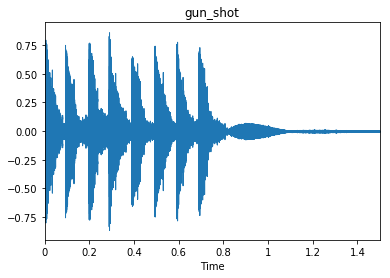

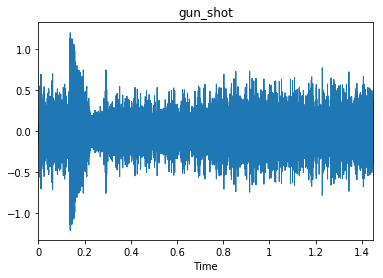

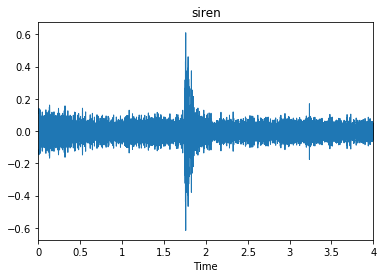

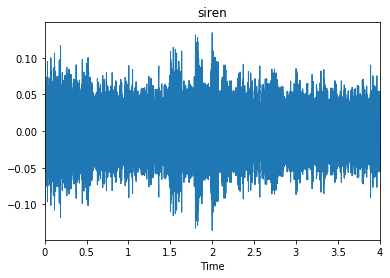

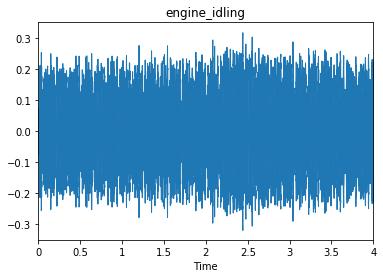

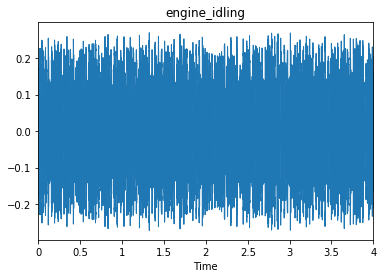

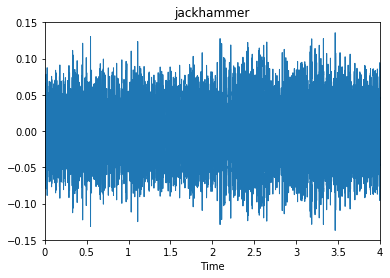

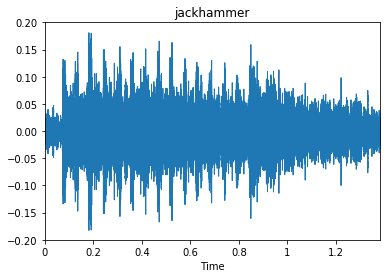

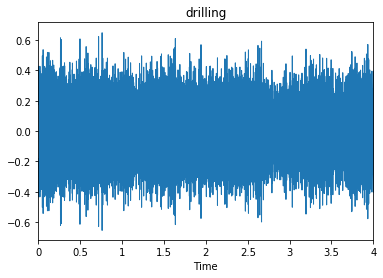

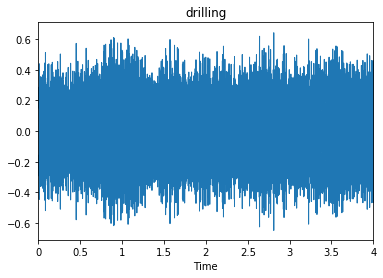

In [7]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        plt.figure()
        lb.display.waveplot(x,sr)
        plt.xlabel('Time')
        plt.title(label)
        plt.show()
        
    

## Discussion:

As can be seen above, the numpy arrays -visually at least- are not the most informative. Moreover, the representation of each sound as a numpy array is memory expensive. 

We investigate looking at mel-scaled spectrogram for the same arrays above.

Mel-scaled spectrograms show the frequency content of a sound with temporal variation. In general a spectrogram shows the frequency content of a wave at different times. That is done by having the x-axis represent time, the y-axis represent different frequency contents. The x-y space is then colored with the corresponding power for a certain frequency at a certain time. 

Studies have shown that human's perception of frequency follows a mel scale (i.e. double the frequency is not perceived as double, but double the mel frequency is). Similarly power is perceived in a logarithmic scale.

Below, we show mel scaled spectrograms (so the y-axis follows a mel scale), and power (i.e the colors in the x-y space) in a logarithmic scale (decibels).

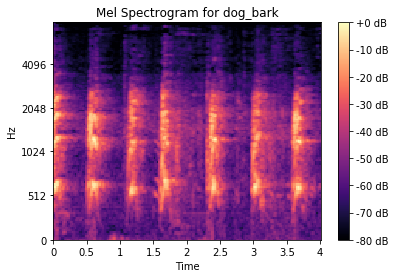

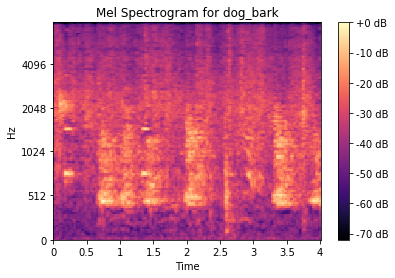

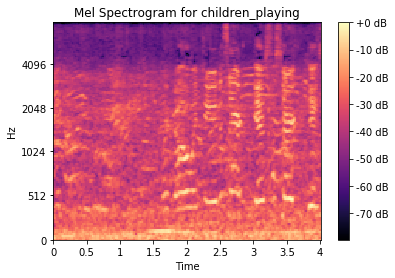

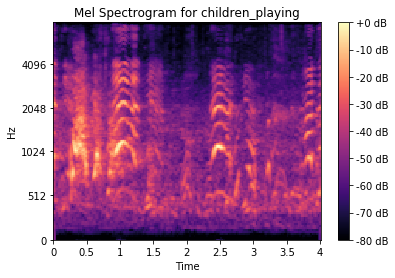

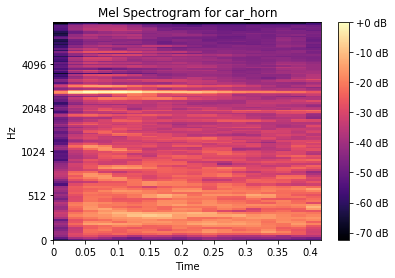

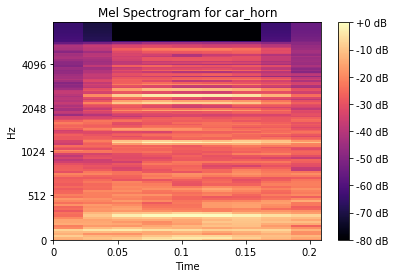

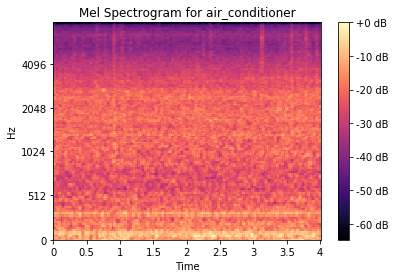

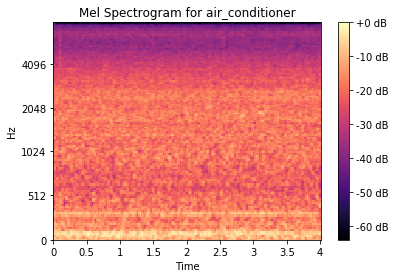

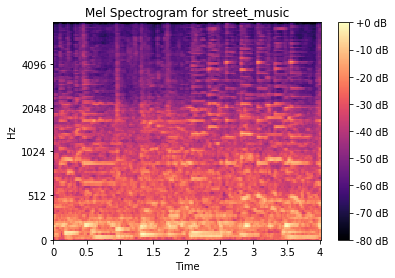

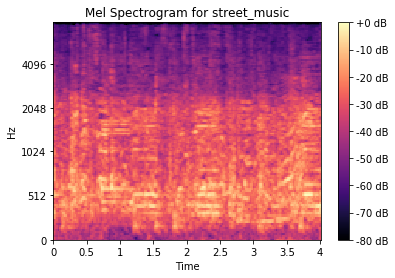

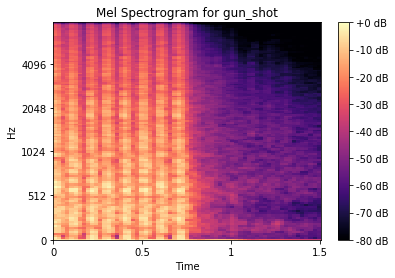

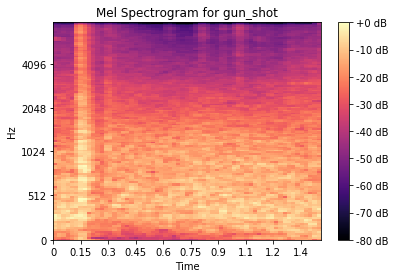

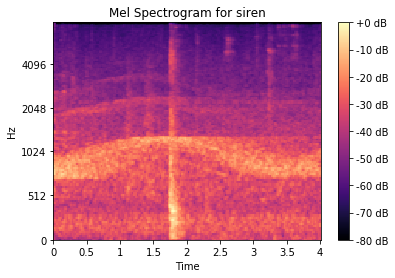

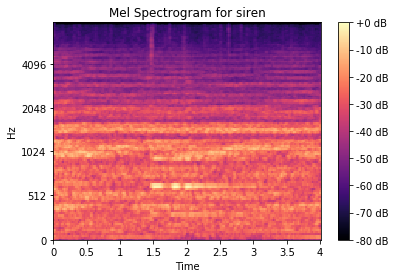

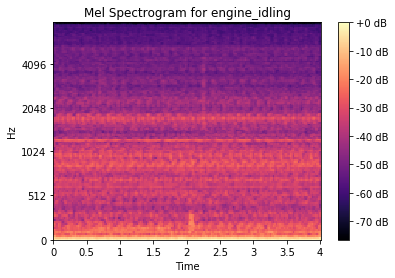

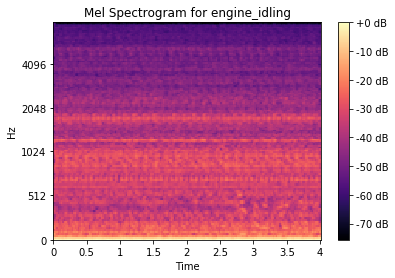

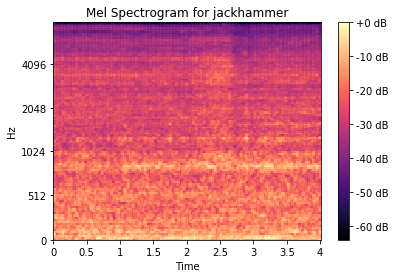

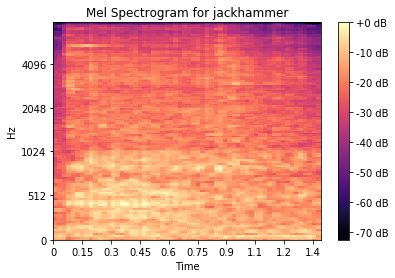

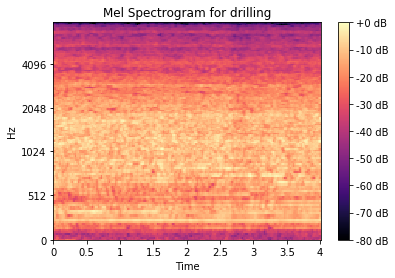

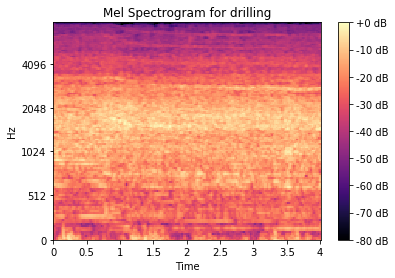

In [8]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        S=lb.feature.melspectrogram(y=x,sr=sr,n_mels=128)
        plt.figure()
        lb.display.specshow(lb.power_to_db(S,ref=np.max),
                           y_axis='mel',
                            fmax=8000,\
                            x_axis='time')

        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram for {}'.format(label))
        plt.show()




    

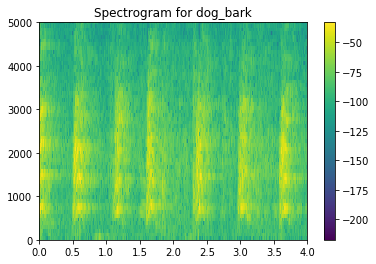

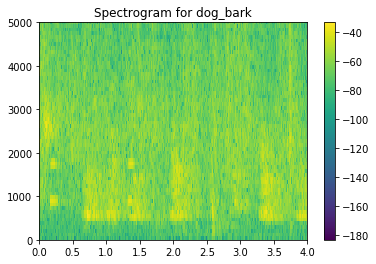

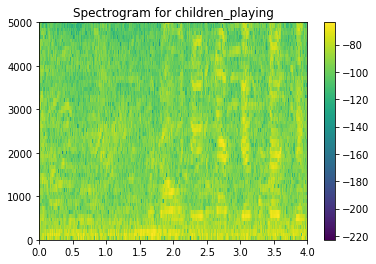

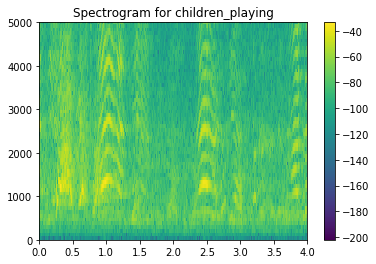

/home/harajlim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


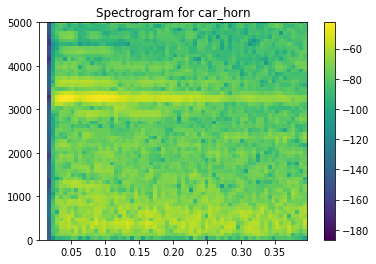

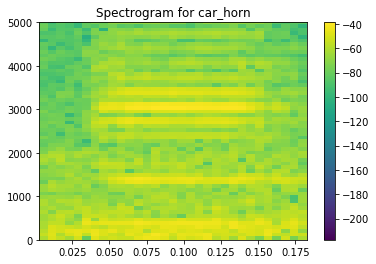

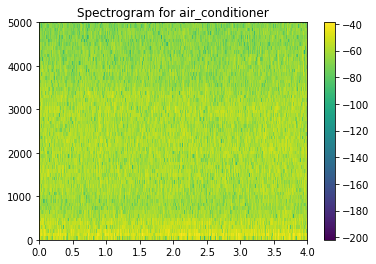

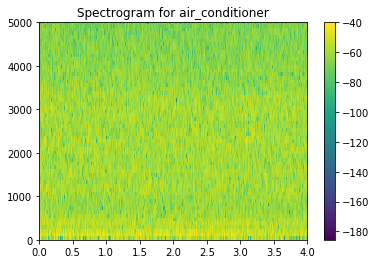

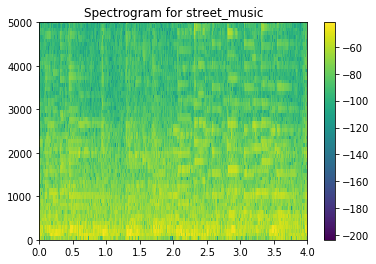

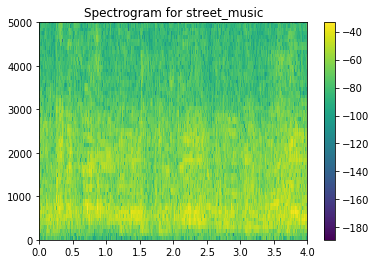

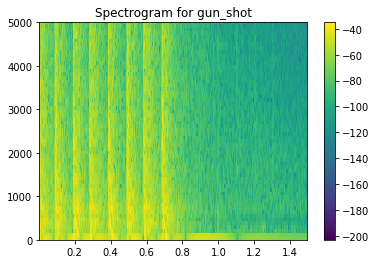

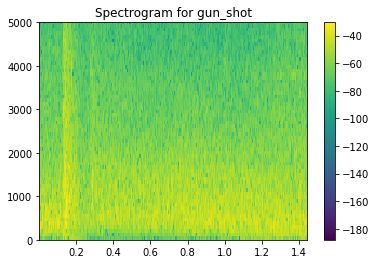

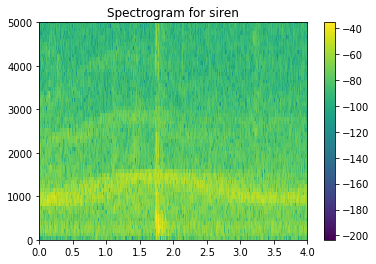

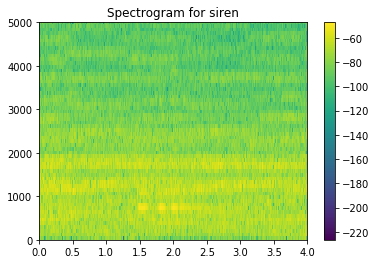

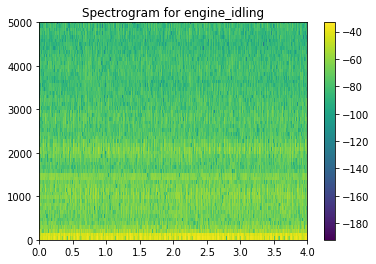

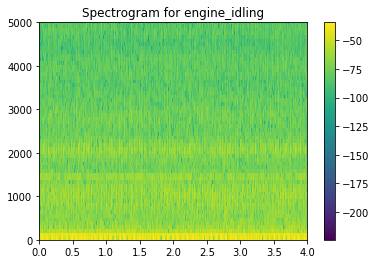

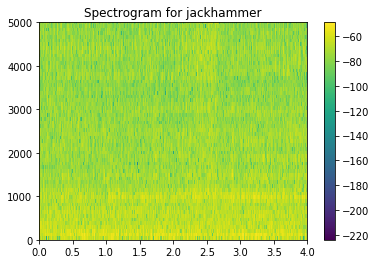

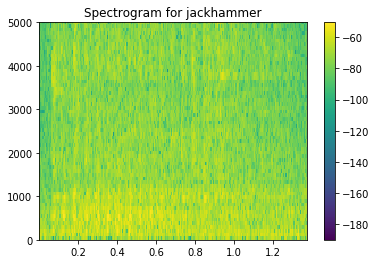

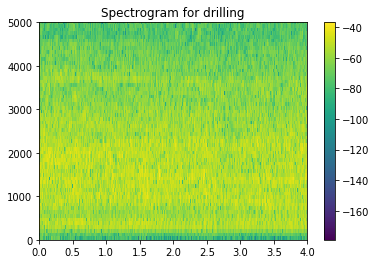

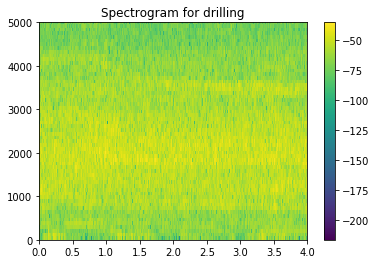

In [9]:
#we also visual specragms from MATPLOTLIB

for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        
        
        plt.figure()
        plt.specgram(x,Fs=sr)
        plt.ylim([0,5000])
        plt.title('Spectrogram for {}'.format(label))
        plt.colorbar()
        plt.show()
        



    

## Discussion:

We can see that visually, mel-based spectrograms can be useful in differentiating sounds.

A big problem in the above is the lack of homogeneity in duration over the data (see gun shot time axis vs others above). This gives us spectrograms of different shapes. This can cause problems when training classification algorithms.


One way of solving this problem is by averaging the spectrograms temporally. The spectrograms thus go from 128 by X matrices, to 128 dimensional vectors (here X is a function of the duration of the sound = duration x sampling_rate).


With doing the above, we lose any information that can be obtained from temporal variations. We average the mel-spectrograms shown above temporally and see if the different sounds can still be differentiated.




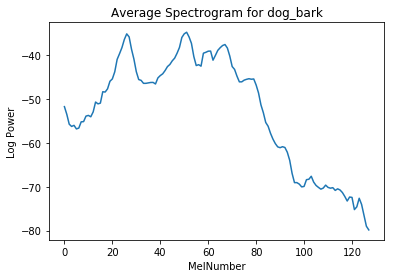

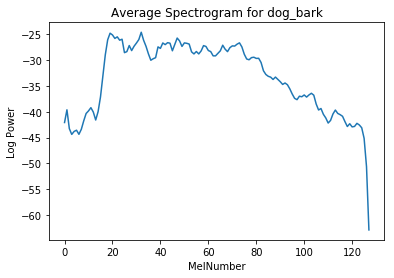

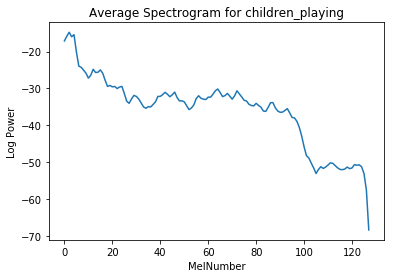

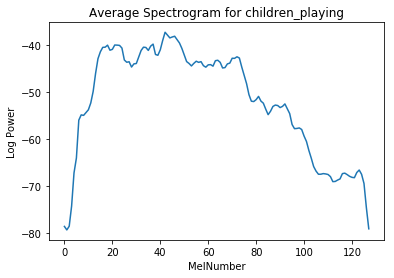

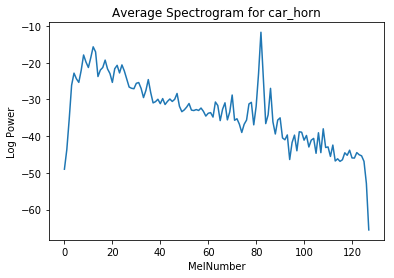

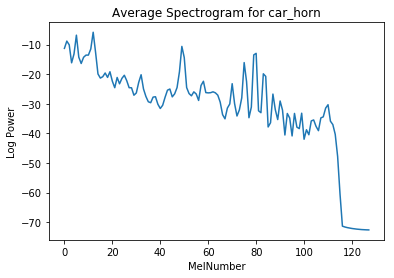

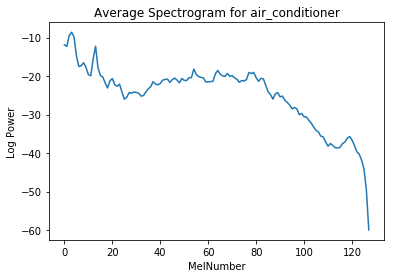

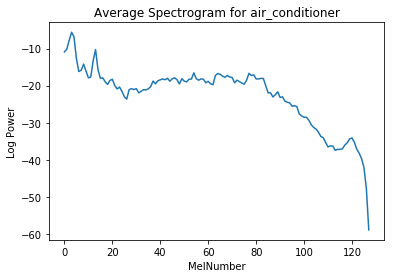

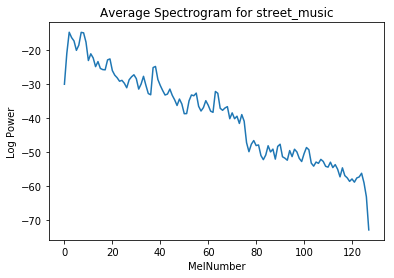

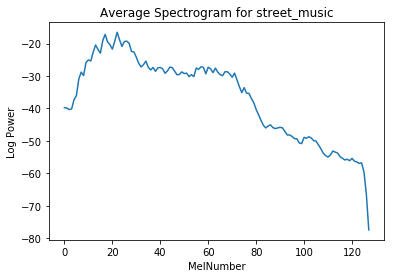

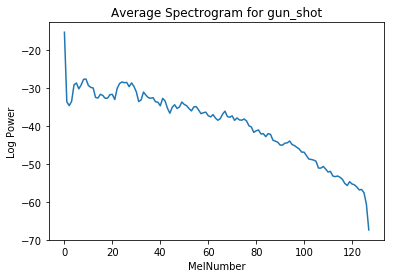

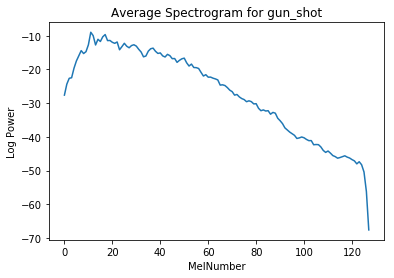

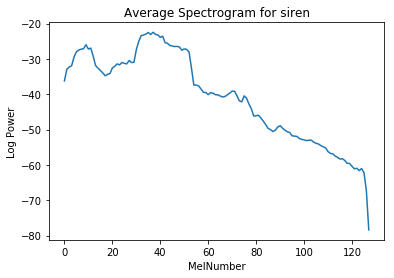

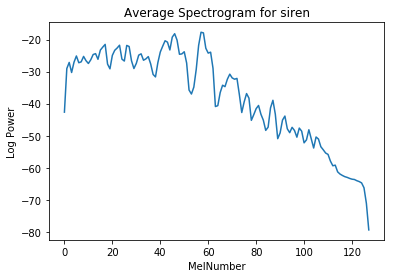

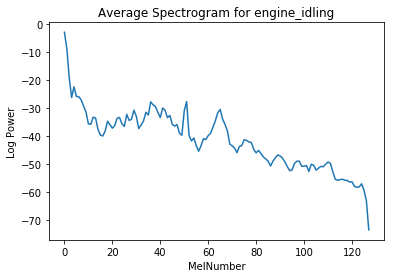

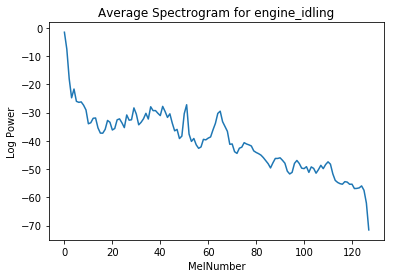

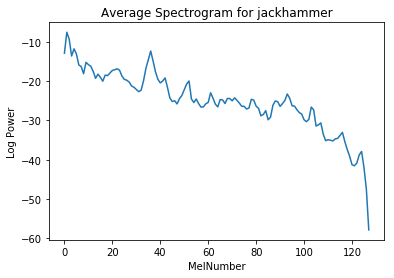

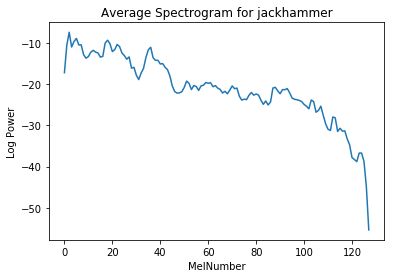

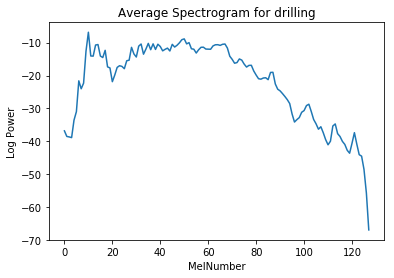

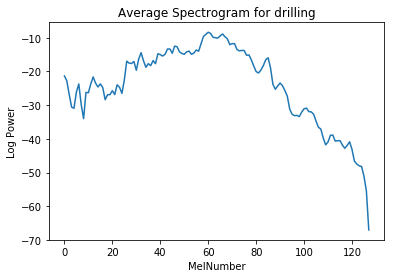

In [10]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        S=lb.feature.melspectrogram(y=x,sr=sr,n_mels=128)
        S=lb.power_to_db(S,ref=np.max)
        S=S.mean(axis=1)
        plt.figure()
        plt.plot(S)
        plt.xlabel('MelNumber')
        plt.ylabel('Log Power')
        plt.title('Average Spectrogram for {}'.format(label))
        plt.show()

## Discussion:

From the above, we actually see that even with temporal averaging, we still see somewhat of a distinction in frequency contents between different sounds, which means that these averaged features may be useful in a classification setting.

Below we discuss a few more features. These features, like the mel-scaled spectrogram also suffer from the need to temporally average to achieve temporally invariant features.

We present these features, and then train several classification models with these features. A discussion about using temporal information is discussed later.



## MFCC Features:


We also present another feature we can obtain using the librosa library, namely MFCC features.
For an explanation of MFCC features see: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum


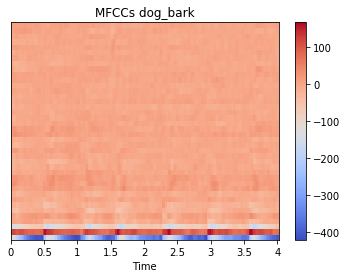

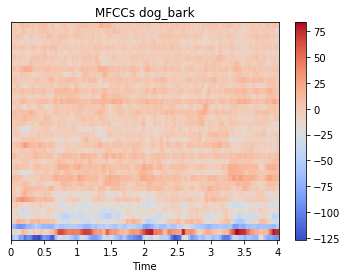

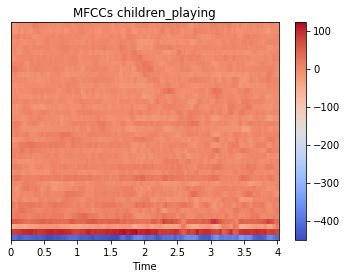

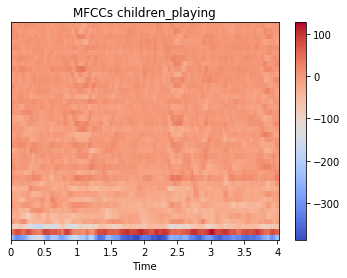

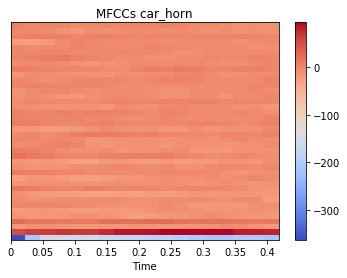

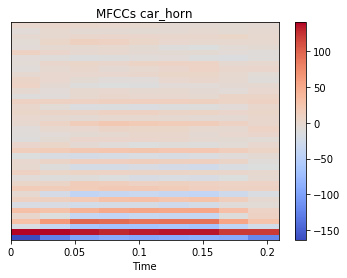

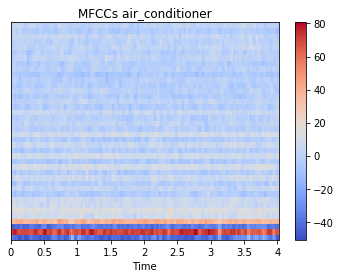

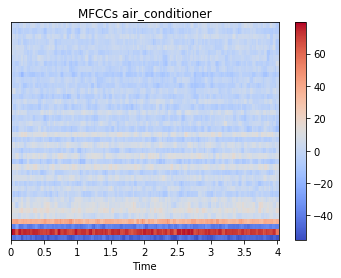

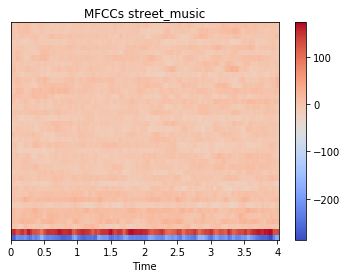

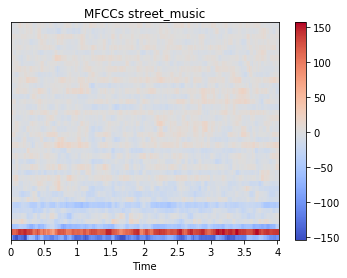

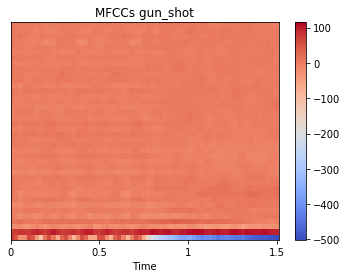

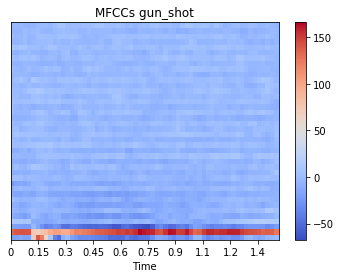

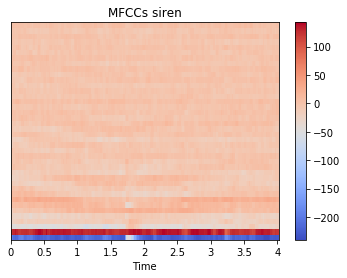

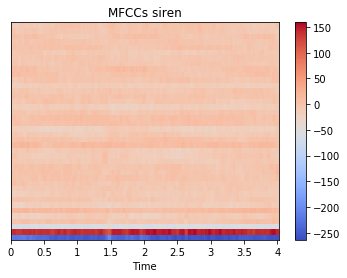

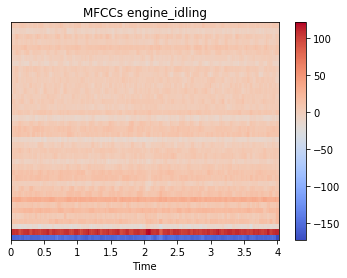

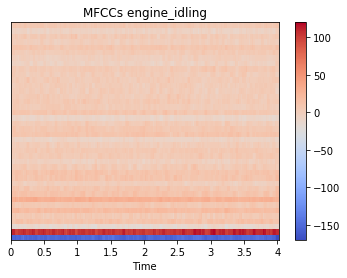

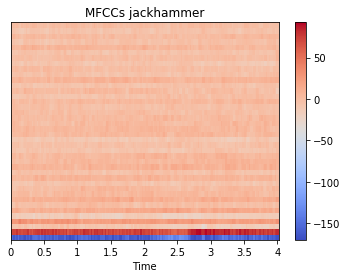

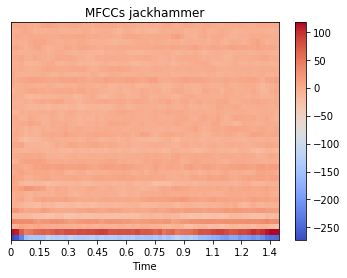

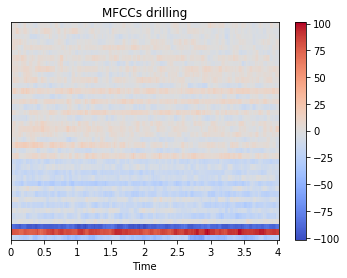

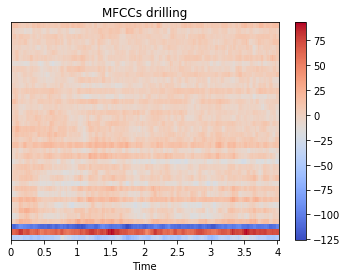

In [11]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        
        mfcc=lb.feature.mfcc(y=x,sr=sr,n_mfcc=40)
        
        plt.figure()
        librosa.display.specshow(mfcc,x_axis='time')
        plt.title('MFCCs {}'.format(label))
        plt.colorbar()
        plt.show()

## Contrast Features:



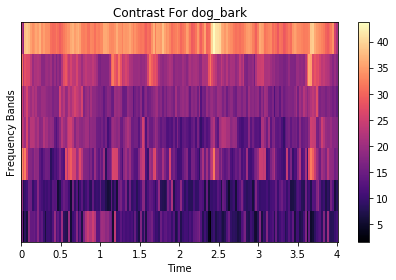

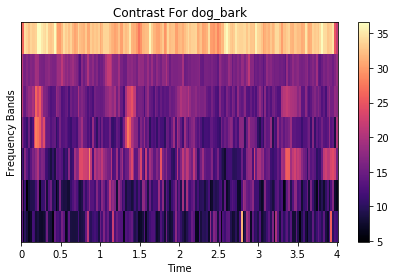

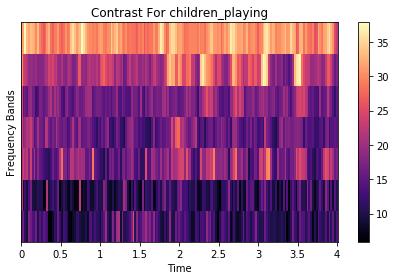

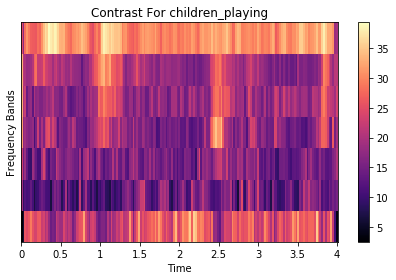

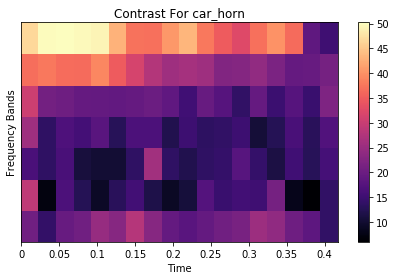

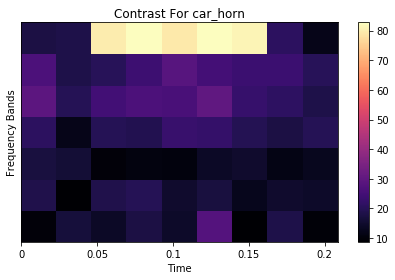

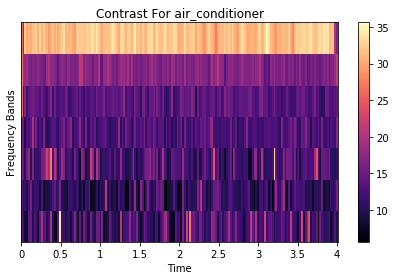

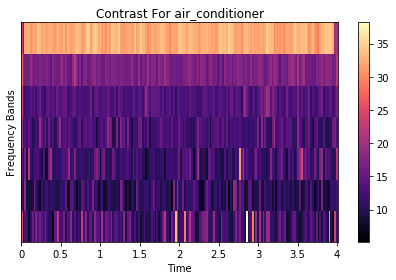

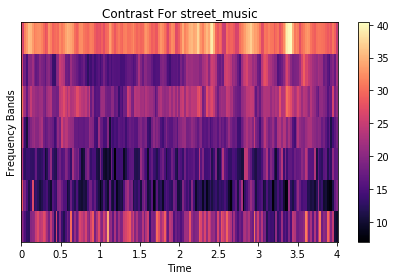

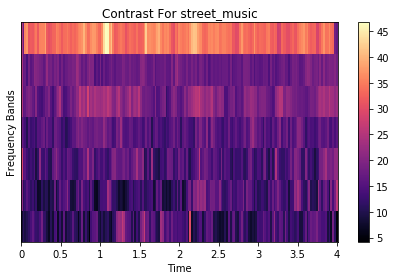

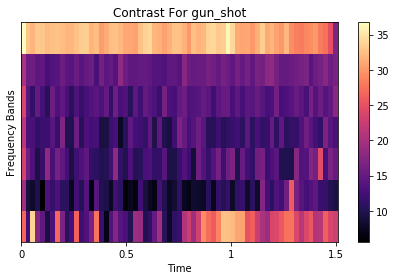

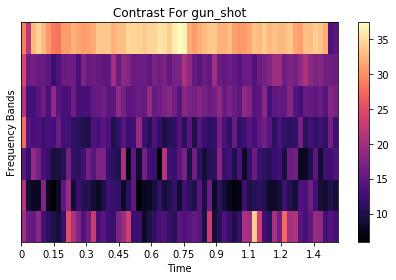

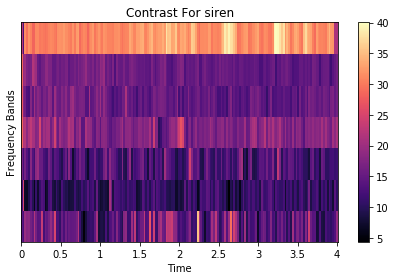

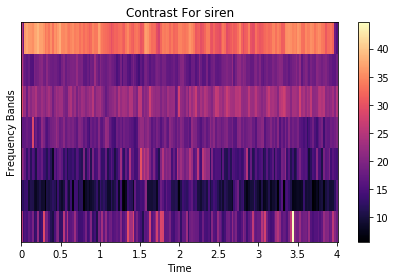

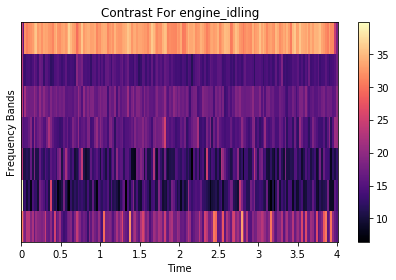

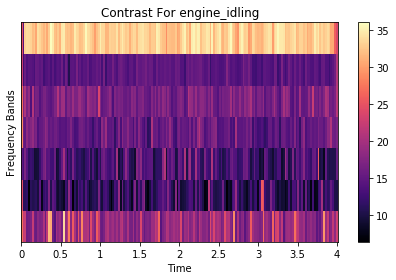

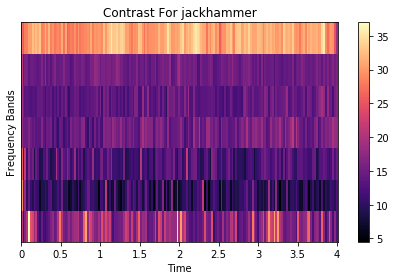

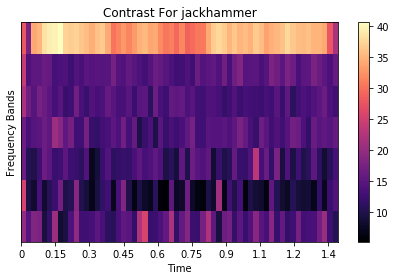

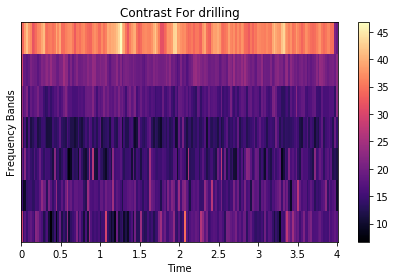

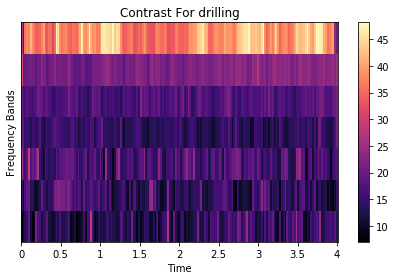

In [12]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        
        stft=np.abs(lb.stft(x))
        contrast=lb.feature.spectral_contrast(S=stft,sr=sr)
        
        plt.figure()
        librosa.display.specshow(contrast,x_axis='time')
        plt.title('Contrast For {}'.format(label))
        plt.ylabel('Frequency Bands')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

## Chroma Features:

Another set of features we extract are called the Chroma features. 

"Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave. Since, in music, notes exactly one octave apart are perceived as particularly similar, knowing the distribution of chroma even without the absolute frequency (i.e. the original octave) can give useful musical information about the audio -- and may even reveal perceived musical similarity that is not apparent in the original spectra."

Above obtained from: https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/

In general, chroma features provide (at a given time) the energy distribution of a sound over the 12 "notes" (C,C#,D,D#,E,F,F#,G,G#,A,A#,B)


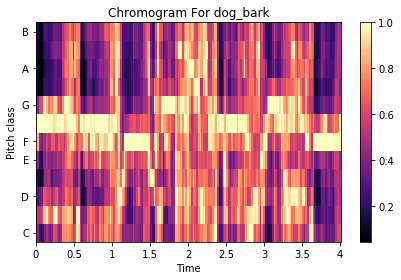

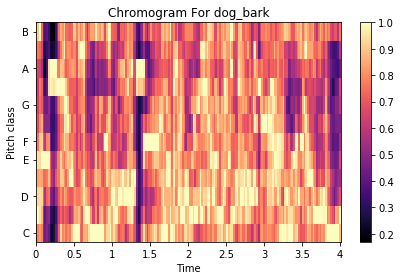

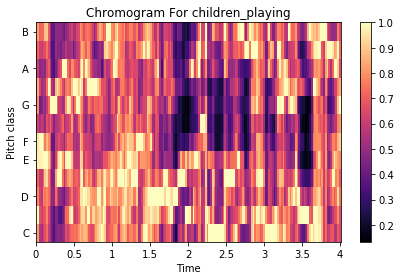

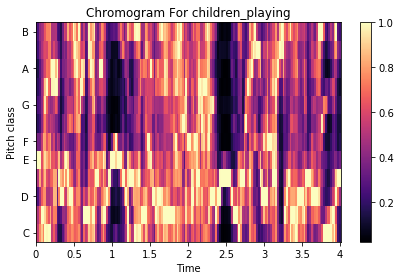

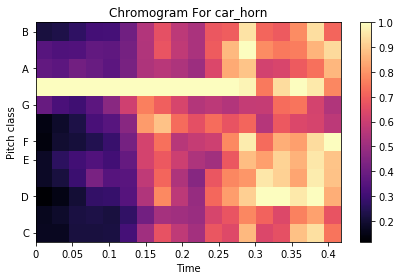

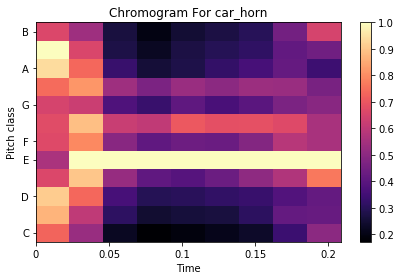

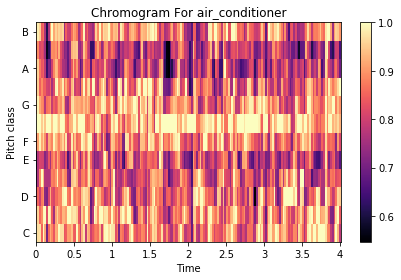

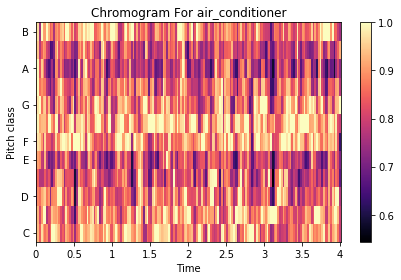

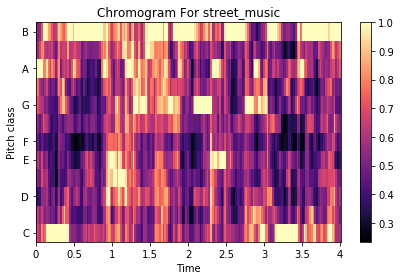

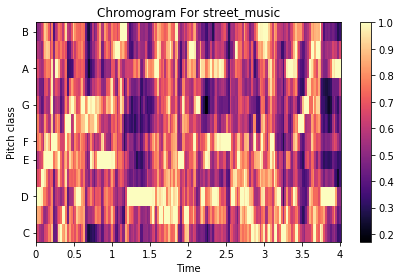

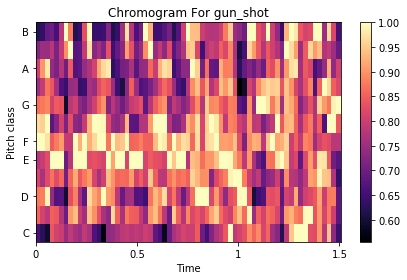

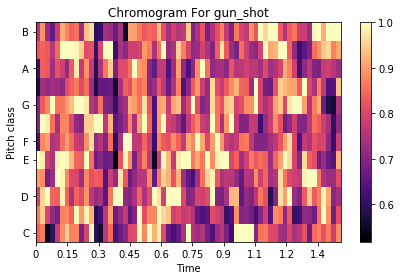

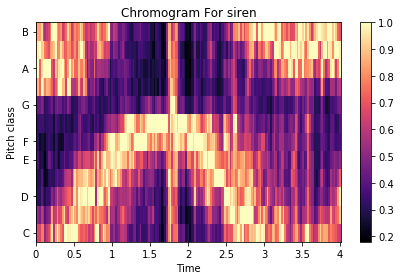

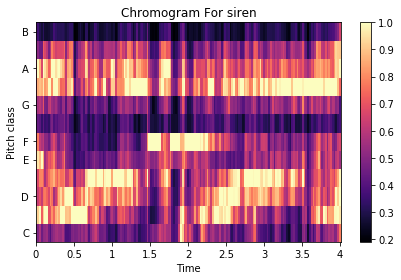

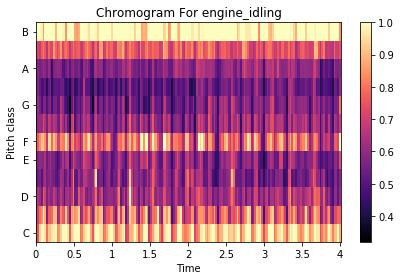

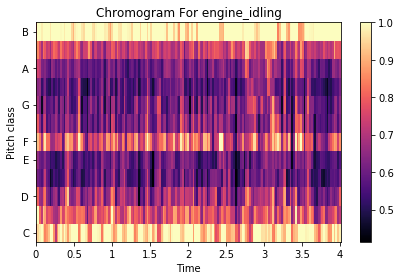

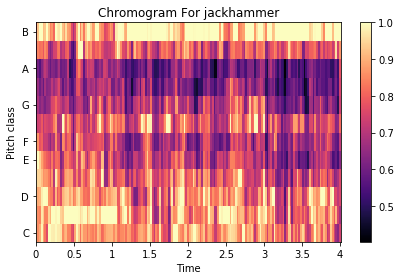

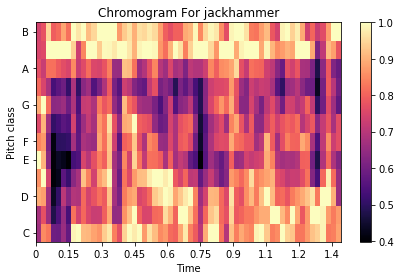

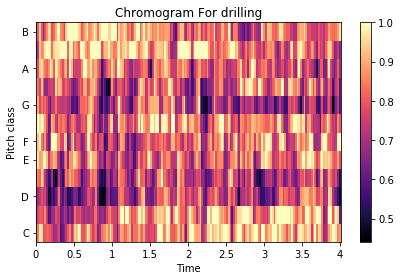

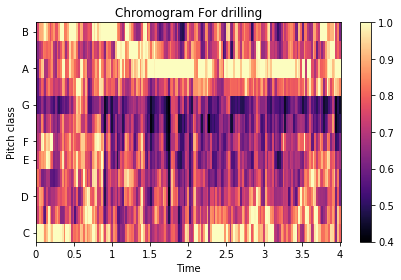

In [13]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        
        stft=np.abs(lb.stft(x))
        chroma=lb.feature.chroma_stft(S=stft,sr=sr)
        
        plt.figure()
        librosa.display.specshow(chroma,y_axis='chroma',x_axis='time')
        plt.title('Chromogram For {}'.format(label))
        plt.colorbar()
        plt.tight_layout()
        plt.show()

## Discussion:

The chromograms above show the musical note that is dominant in the sound and its variation in time. This can be particulary useful for things like car horns (which appear as a dominant horizontal line), and sirens (which appear as a wave). We note that temporally averaging the above for things like the siren might cause a major loss of information.

## Tonnetz Features:

See: https://en.wikipedia.org/wiki/Tonnetz

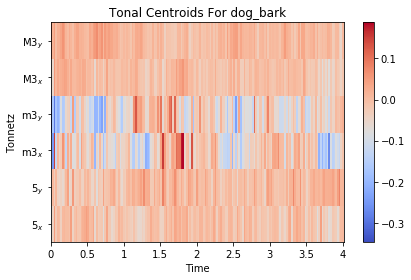

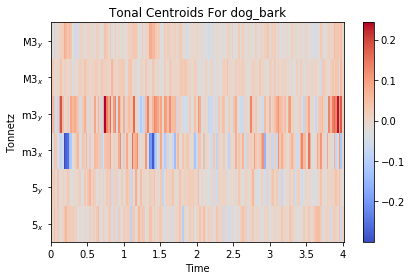

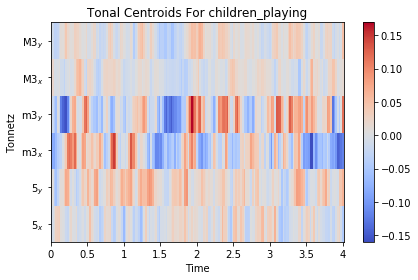

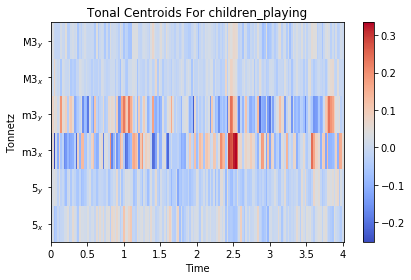

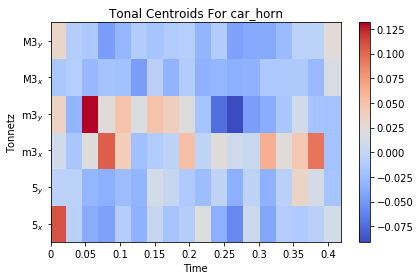

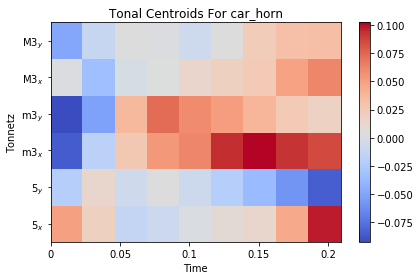

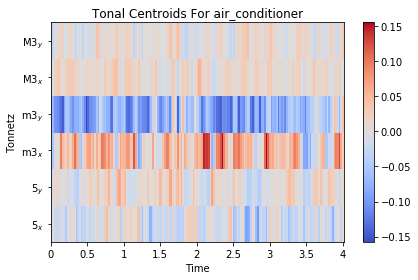

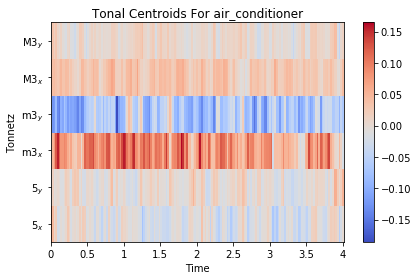

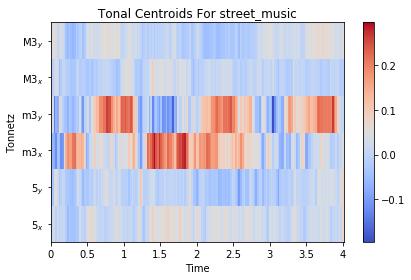

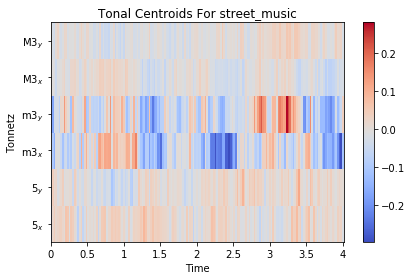

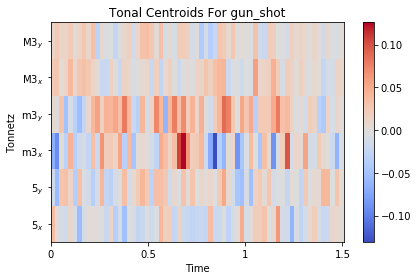

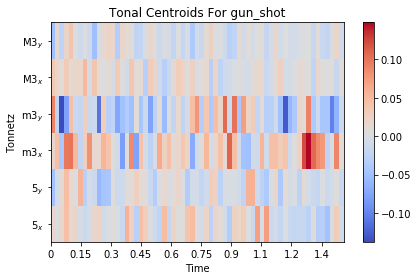

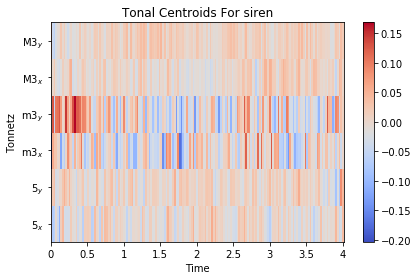

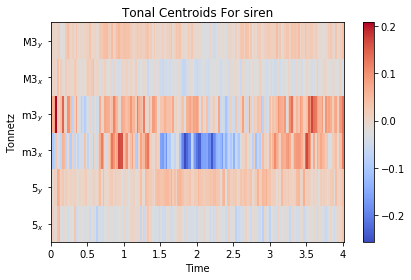

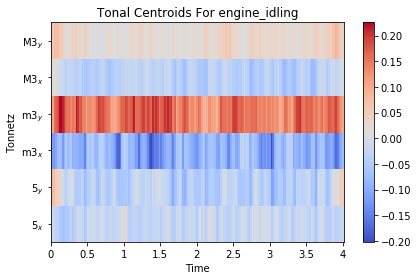

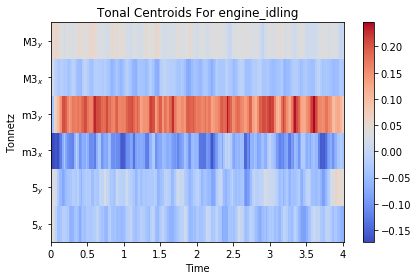

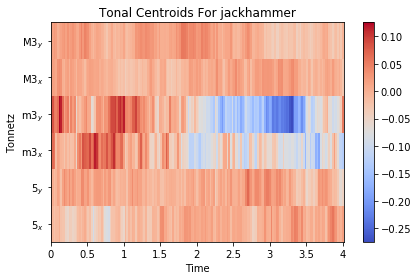

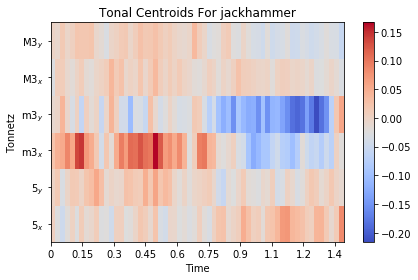

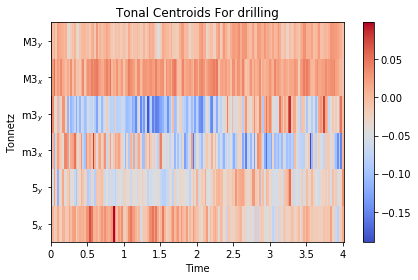

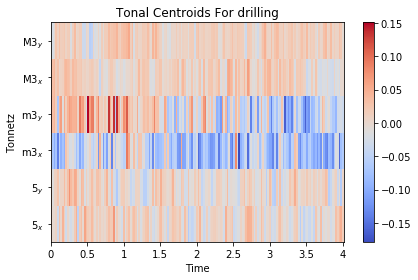

In [14]:
for label in labels:
    for i,entry in enumerate(samples[label]):
        fold=samples[label+'fold'][i]
        filepath='AllData/UrbanSound8K/audio/fold'+str(fold) +'/' +entry
        x,sr=ReadAudio(filepath)
        
        x=lb.effects.harmonic(x)
        tonnetz=lb.feature.tonnetz(y=x,sr=sr)
        
        plt.figure()
        librosa.display.specshow(tonnetz,y_axis='tonnetz',x_axis='time')
        plt.title('Tonal Centroids For {}'.format(label))
        plt.colorbar()
        plt.tight_layout()
        plt.show()

## Feature extraction for all sounds:
For every entry in the dataframe key, we extract: MelSpectrogram features.

We get the features by running GetFeatures.py.

GetFeatures.py pickles 5 matrices: 

An 8732 by 128 MelFeatures.pickle numpy array

An 8732 by 40 MFCC.pickle numpy array

An 8732 by 12 ChromaFeatures.pickle numpy array

An 8732 by 7 ContrastFeatures.pickle numpy array

An 8732 by 6 tonnetzFeatures.pickle numpy array




In [15]:
#we load the pickle files and build a features matrix.

with open('AllData/Pickles/DataInformation.pickle', 'rb') as file:
    key=pickle.load(file)
    
with open('AllData/Pickles/MelFeatures2.pickle', 'rb') as file:
    MelFeatures=pickle.load(file) 

with open('AllData/Pickles/MFCCFeatures.pickle', 'rb') as file:
    MFCC=pickle.load(file) 

with open('AllData/Pickles/ChromaFeatures.pickle', 'rb') as file:
    chroma=pickle.load(file)

with open('AllData/Pickles/ContrastFeatures.pickle', 'rb') as file:
    contrast=pickle.load(file)

with open('AllData/Pickles/tonnetzFeatures.pickle', 'rb') as file:
    tonnetz=pickle.load(file)
    
features=np.concatenate((MelFeatures,MFCC,chroma,contrast,tonnetz),axis=1)
y=key['class'].values

DF=pd.DataFrame(features)

print(DF.shape)
key=pd.concat([key,DF],axis=1)
x1,y1=key.shape
print(key.shape)

key=key.dropna()
print(key.shape)
x2,y2=key.shape



print('{} Rows were dropped and {} columns were dropped'.format(x1-x2,y1-y2))

#with open('AllData/Pickles/AveragedFeatures.pickle','wb') as file:
#    pickle.dump(features,file)

(8732, 193)
(8732, 201)
(8731, 201)
1 Rows were dropped and 0 columns were dropped


In [16]:
key.shape

(8731, 201)

In [17]:
features.shape

(8732, 193)

In [18]:
#we try a tenfold cross validation scheme with a random forest:

from sklearn.ensemble import RandomForestClassifier

accuracy=[]

for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=features[itest,:]
    Xtrain=features[itrain,:]
    ytest=y[itest]
    ytrain=y[itrain]
    model=RandomForestClassifier(n_estimators=100)
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 


0
1
2
3
4
5
6
7
8
9
[0.5619266055045872, 0.5968468468468469, 0.5027027027027027, 0.5626262626262626, 0.6335470085470085, 0.5492102065613609, 0.6408114558472554, 0.598014888337469, 0.6482843137254902, 0.6200716845878136]
The mean of accuracy over the folds is 0.5914041975286797


In [19]:
from sklearn.model_selection import cross_val_score
model=RandomForestClassifier(n_estimators=100)
X=MelFeatures[:]
scores=cross_val_score(model,X,y,cv=10)
print(scores)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 

[0.47254005 0.60411899 0.54805492 0.56407323 0.66437572 0.5395189
 0.5486827  0.49942726 0.44215349 0.45350172]
The mean of accuracy over the folds is 0.5914041975286797


## Discussion:

As seen above, we get better results when we cross-validate with randomly selected folds. This is due to what leakage occurs between the training and testing data. 

As mentioned before, certain .wav files are slices of the same sound file and are very similar in nature. When two slices from the same sound are put in both the training and testing folds we get an artificially inflated accuracy score.


## Other Classification Models:

Below we use multiclass SVM, Naive Baye's, K-NN, as well as a simple neural network.

In [20]:
#Linear SVM:

from sklearn.svm import LinearSVC
accuracy=[]
for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=features[itest,:]
    Xtrain=features[itrain,:]
    ytest=y[itest]
    ytrain=y[itrain]
    model=LinearSVC()
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 


0
1
2
3
4
5
6
7
8
9
[0.3451834862385321, 0.3367117117117117, 0.3254054054054054, 0.4090909090909091, 0.4166666666666667, 0.2284325637910085, 0.35918854415274465, 0.44292803970223327, 0.4019607843137255, 0.4910394265232975]
The mean of accuracy over the folds is 0.37566075375962343


In [21]:
#Naive Baye's Classifier

from sklearn.naive_bayes import GaussianNB
accuracy=[]
for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=features[itest,:]
    Xtrain=features[itrain,:]
    ytest=y[itest]
    ytrain=y[itrain]
    model=GaussianNB()
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 


0
1
2
3
4
5
6
7
8
9
[0.30160550458715596, 0.3277027027027027, 0.28, 0.25353535353535356, 0.3696581196581197, 0.34264884568651277, 0.28997613365155134, 0.45409429280397023, 0.36151960784313725, 0.3751493428912784]
The mean of accuracy over the folds is 0.33558899033597817


In [22]:
#K-NN Classifier

from sklearn.neighbors import KNeighborsClassifier
accuracy=[]
for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=features[itest,:]
    Xtrain=features[itrain,:]
    ytest=y[itest]
    ytrain=y[itrain]
    model=KNeighborsClassifier(n_neighbors=80)
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 


0
1
2
3
4
5
6
7
8
9
[0.41743119266055045, 0.356981981981982, 0.3654054054054054, 0.36262626262626263, 0.3952991452991453, 0.353584447144593, 0.42601431980906923, 0.4441687344913151, 0.44362745098039214, 0.3739545997610514]
The mean of accuracy over the folds is 0.3939093540159767


In [23]:
#MLP Classifier
from sklearn.neural_network import MLPClassifier
accuracy=[]
for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=features[itest,:]
    Xtrain=features[itrain,:]
    ytest=y[itest]
    ytrain=y[itrain]
    model=MLPClassifier(hidden_layer_sizes=(1000,1000),activation='logistic')
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 


0
1
2
3
4
5
6
7
8
9
[0.5894495412844036, 0.5461711711711712, 0.47135135135135137, 0.5787878787878787, 0.6239316239316239, 0.5467800729040098, 0.6229116945107399, 0.5248138957816377, 0.633578431372549, 0.5973715651135006]
The mean of accuracy over the folds is 0.5735147226208867


In [24]:
# We also try RandomForest again with more trees.

from sklearn.ensemble import RandomForestClassifier

accuracy=[]

for testFold in range(10):
    print(testFold)
    itest=key[key['fold']==testFold+1].index.values
    itrain=key[key['fold']!=testFold+1].index.values
    Xtest=features[itest,:]
    Xtrain=features[itrain,:]
    ytest=y[itest]
    ytrain=y[itrain]
    model=RandomForestClassifier(n_estimators=1000)
    model.fit(Xtrain,ytrain)
    accuracy.append(model.score(Xtest,ytest))
    
print(accuracy)
print('The mean of accuracy over the folds is {}'.format(np.mean(np.array(accuracy)))) 


0
1
2
3
4
5
6
7
8
9
[0.5619266055045872, 0.597972972972973, 0.49513513513513513, 0.5646464646464646, 0.6335470085470085, 0.5613608748481167, 0.6181384248210023, 0.6004962779156328, 0.6397058823529411, 0.5651135005973715]
The mean of accuracy over the folds is 0.5838043147341233


## Discussion:

As can be seen above, without any hyperparameter tuning, MLP and random forests perform the best with an accuracy of around 0.59.

We take a close look at random forests to understand how well the algorithm is perform (beyond just looking at accuracy score).


In [25]:

testFold=5 #the test fold that performed bes
#print(testFold)
itest=key[key['fold']==testFold].index.values
itrain=key[key['fold']!=testFold].index.values
Xtest=features[itest,:]
Xtrain=features[itrain,:]
ytest=y[itest]
ytrain=y[itrain]
model=RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain,ytrain)
accuracy.append(model.score(Xtest,ytest))




5


We show the normalized confusion matrix using: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


Normalized confusion matrix
[[0.18       0.         0.16       0.22       0.         0.08
  0.         0.31       0.05       0.        ]
 [0.         0.56122449 0.05102041 0.         0.02040816 0.02040816
  0.         0.02040816 0.01020408 0.31632653]
 [0.         0.         0.61       0.07       0.18       0.02
  0.         0.02       0.         0.1       ]
 [0.08       0.         0.09       0.71       0.01       0.01
  0.01       0.         0.04       0.05      ]
 [0.01       0.         0.02       0.11       0.58       0.
  0.02       0.22       0.         0.04      ]
 [0.06542056 0.         0.07476636 0.         0.01869159 0.44859813
  0.         0.3364486  0.         0.05607477]
 [0.         0.         0.         0.05       0.025      0.
  0.925      0.         0.         0.        ]
 [0.04166667 0.         0.         0.         0.025      0.
  0.         0.925      0.         0.00833333]
 [0.         0.         0.02816901 0.32394366 0.         0.
  0.         0.         0.63380282

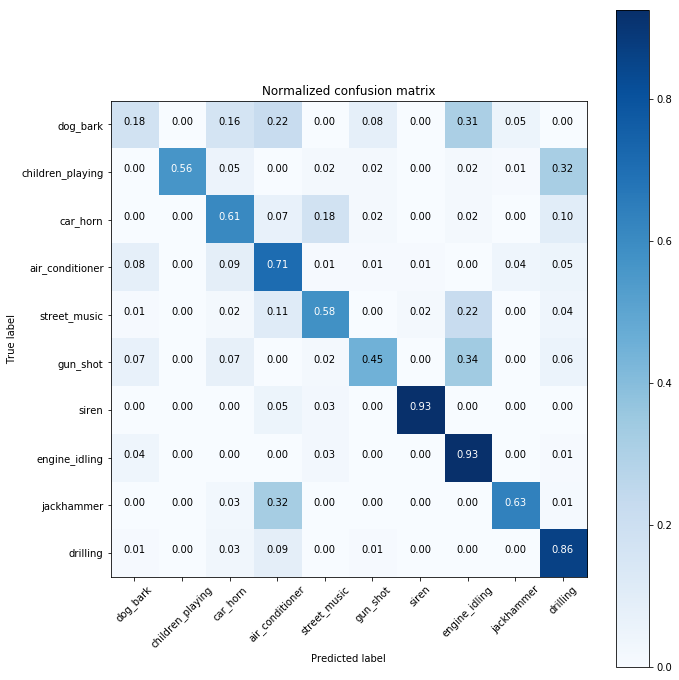

In [35]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest,model.predict(Xtest))
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

                              


# we also print out precision, recall and f1-scores for each class:

In [37]:

from sklearn.metrics import classification_report
print(classification_report(ytest, model.predict(Xtest), target_names=labels))

                  precision    recall  f1-score   support

        dog_bark       0.45      0.18      0.26       100
children_playing       1.00      0.56      0.72        98
        car_horn       0.58      0.61      0.59       100
 air_conditioner       0.49      0.71      0.58       100
    street_music       0.68      0.58      0.63       100
        gun_shot       0.77      0.45      0.57       107
           siren       0.93      0.93      0.93        40
   engine_idling       0.54      0.93      0.69       120
      jackhammer       0.82      0.63      0.71        71
        drilling       0.60      0.86      0.70       100

     avg / total       0.66      0.63      0.62       936



## Thinking ahead:

As mentioned before, a lot of information was lost by temporally averaging bins in the features above.
This was done due to what duration differences existed between the data.

To try and make the data homogenous, all sounds less than 4s are converted to 4s sounds. This is done as follows:

1-Given a sound S of duration x with x<4s:

2-If 4 - x >= x then concatenate S with itself. If the new S is still less the 4s go to 1-

3-If 4 - x < x then concatenate S with the first 4-x elements of itself. End

After having all sounds with identical durations, all extracted features mentioned above should have identical dimensionality.

in GetFullFeatures.py we implement the sound augmentation as mentioned above, and extract the melspectrograms only.

To have features sizes that are manageable on my local machine, mel-spectrograms with 40 bins are extracted from the 16000 sampling rate representation of a sound. This reduces the feature dimensionality.

Running the code results in around a 0.5 accuracy score, as shown below. That is lower that the algorithm shown above, HOWEVER:

1-GetFullFeatures only used mel-spectrograms as a feature,

2-GetFullFeatures uses a very coarse mel-spectrogram.





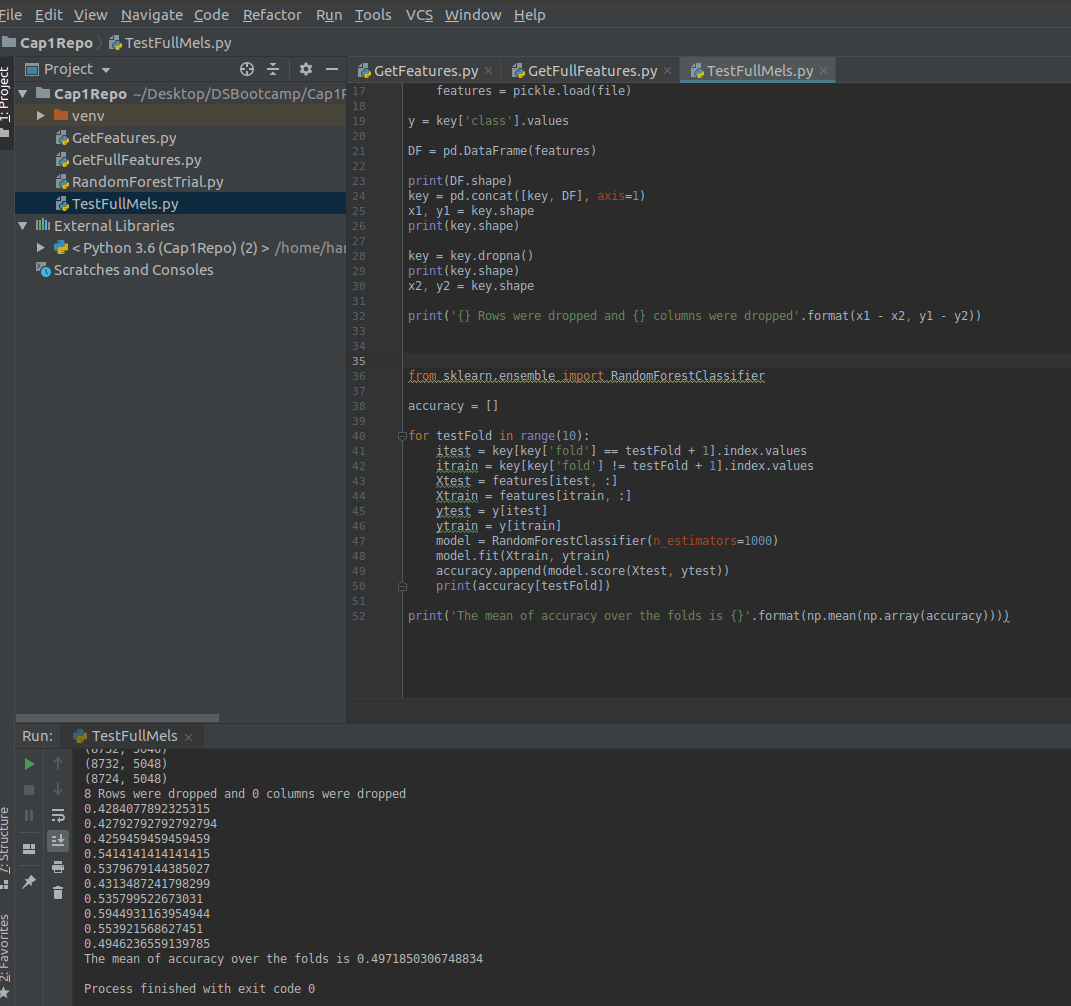

## Conclusions:

In the final report, hyper parameter tuning is discussed, as well as a deeper discussion regarding the errors in the above classification models.